In [1]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Infrastruture

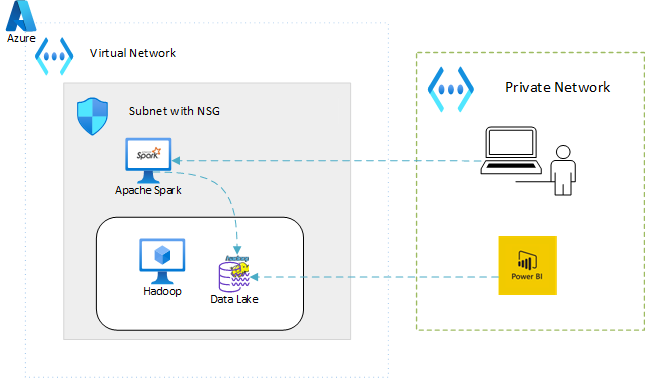

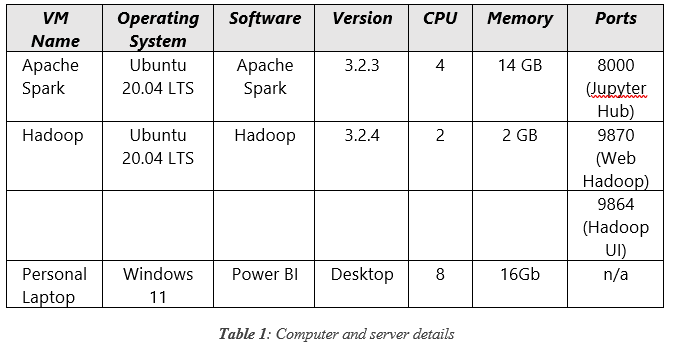

# Loading (remote) E-OBS observations and summer days (SU) calculation

Git repo: https://github.com/rmsryu/spark-climate-data.git
Data set: https://www.ecad.eu/download/ensembles/download.php

E-OBS data is loaded from the remote OpenDAP repository at KNMI. Please, note that when new versions become available the link is no longer valid since the URL is updated with the version number. Therefore, if the code below doesn't work please check the current E-OBS version and update the URL (https://www.ecad.eu/download/ensembles/download.php). 

# Study of daily precipitation of Weather Station in Netherlands

The raw data are from the 8-8 observational network, the day is the day of the observation, most rain fell on the previous day. The homogenised set has been corrected statistically for breaks in the monthly sum in comparisons with neighbouring stations. The lowering of the observation height from 1.5m to 0.4m around 1950 has not been corrected for. This reduced the undercatch by about 3% but the correction depends strongly on the location and weather. A first order correction for measurement problems 2012-2017 has been added.

- Main page: https://climexp.knmi.nl/PhomNL.cgi?id=someone@somewhere
- Stations List: https://climexp.knmi.nl/getdutchstations.cgi?id=someone@somewhere&TYPE=rr
- Station Details: https://www.knmi.nl/nederland-nu/klimatologie/monv/reeksen
- Example Data source: https://climexp.knmi.nl/data/rrrr458.dat

Data provide by: Royal Netherlands Meteorological Institute (KNMI)

In [2]:
import numpy as np
import pandas as pd
import requests
from pyspark import SparkFiles
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [30]:
import warnings
warnings.filterwarnings("ignore")


In [31]:
hadoopUrl = 'hdfs://hadoop-vm.internal.cloudapp.net:9000'
hadoopWeb = 'http://hadoop-vm.internal.cloudapp.net:9870'

def save_stations_to_hadoop():
   # Define the schema of the CSV file
    schema_stations = StructType([
        StructField("station", StringType(), True),
        StructField("name", StringType(), True),
        StructField("latitude", FloatType(), True),
        StructField("longitude", FloatType(), True),
        StructField("website", StringType(), True),
        StructField("rawdata", StringType(), True),
        StructField("filename", StringType(), True),
        StructField("from", StringType(), True),
        StructField("to", StringType(), True)
    ])

    # Read the CSV file with headers and the defined schema
    df_stations = spark.read.format("csv").option("header", "true").schema(schema_stations).load('data/nederland_stations_precipitation_8-8.csv')
    # Convert the "From" and "To" columns to datetime format
    df_stations = df_stations.withColumn("from", to_date("from", "yyyyMMdd"))
    df_stations = df_stations.withColumn("to", to_date("to", "yyyyMMdd"))

    # Write the dataframe to Hadoop as csv
    df_stations.write.format("csv").mode("overwrite").option("mergeSchema", "true").save(f"{hadoopUrl}/precipitation/data/stations")


In [32]:
# Save stations for later in data lake
save_stations_to_hadoop()

{"mdc":{"mdc.taskName":"task 0.0 in stage 11.0 (TID 11)"},"@version":1,"source_host":"rmsryu-vm","message":"CSV header does not conform to the schema.\n Header: StationCode, Name, Lat, Lon, WebSite, RawData, FileName, From, To\n Schema: station, name, latitude, longitude, website, rawdata, filename, from, to\nExpected: station but found: StationCode\nCSV file: file:///home/rmsryu/notebooks/CA1/spark-climate-data/data/nederland_stations_precipitation_8-8.csv","thread_name":"Executor task launch worker for task 0.0 in stage 11.0 (TID 11)","@timestamp":"2023-04-02T11:18:29.676+0000","level":"WARN","logger_name":"org.apache.spark.sql.catalyst.csv.CSVHeaderChecker"}


In [17]:
stations = pd.read_csv('data/nederland_stations_precipitation_8-8.csv',dtype='str')
stations.head()

,StationCode,Name,Lat,Lon,WebSite,RawData,FileName,From,To
0,458,Aalsmeer,52.25,4.77,https://climexp.knmi.nl/getdutchrr.cgi?id=some...,https://climexp.knmi.nl/data/rrrr458.dat,rrrr458.data,19270102,20230310
1,040,Aalsum bij Dokkum,-999.9,-999.9,https://climexp.knmi.nl/getdutchrr.cgi?id=some...,https://climexp.knmi.nl/data/rrrr040.dat,rrrr040.data,18921229,19250930
2,680,Aalten,51.9,6.55,https://climexp.knmi.nl/getdutchrr.cgi?id=some...,https://climexp.knmi.nl/data/rrrr680.dat,rrrr680.data,19040802,20230310
3,711,Aardenburg,-999.9,-999.9,https://climexp.knmi.nl/getdutchrr.cgi?id=some...,https://climexp.knmi.nl/data/rrrr711.dat,rrrr711.data,18731201,18870630
4,572,Abcoude,52.25,4.97,https://climexp.knmi.nl/getdutchrr.cgi?id=some...,https://climexp.knmi.nl/data/rrrr572.dat,rrrr572.data,19300902,20230310


In [4]:
errors = []
for index, row in stations.iterrows():
    station = row['StationCode']
    stationWebSite = row['WebSite']
    rawData = row['RawData']
    fileName = row['FileName']
    
    # Check station exits in hdfs (use parquet sucsess file)
    hdfs_path = f"{hadoopWeb}/webhdfs/v1/precipitation/data/{station}/_SUCCESS?op=LISTSTATUS"
    
    # download data if not present
    if requests.get(hdfs_path).status_code == 404:    
        # To generate raw data needs to call main station page for the 8-8 hours dataset to be generated
        print(f"Generating data {stationWebSite}")
        response = requests.get(stationWebSite)
        # check the response status code
        if response.status_code == 200:
            # save file to hdfs
            try:
                # Add file to spark context
                print(f"Adding File {rawData}")
                spark.sparkContext.addFile(rawData)
                df = spark.read.text(SparkFiles.get(fileName))
                df = df.filter(df['value'].substr(0, 1) != '#') \
                    .filter(df['value'].substr(0, 1) != '%') \
                    .withColumn('date', to_date(substring(df['value'], 1, 8), 'yyyyMMdd')) \
                    .withColumn('precipitation', split(df['value'], '\s+')[1]) \
                    .withColumn('station', lit(station)) \
                    .select('station','date', 'precipitation') \
                    .orderBy('station','date')
            
                df.write.mode("overwrite").parquet(f"{hadoopUrl}/precipitation/data/{station}")
            except Exception as e:
                # print an error message
                print(f"Fail to write parquet file for {response.status_code}")
                print(e)
                errors.append(station)
        else:
            # print an error message
            print(f"Request failed with status code {response.status_code} for station {station}")
            errors.append(station)
    else:
        print(f"Skipping {station}..")
    



Skipping 458..
Skipping 040..
Skipping 680..
Skipping 711..
Skipping 572..
Skipping 045..
Skipping 089..
Skipping 200..
Skipping 664..
Skipping 678..
Skipping 363..
Skipping 169..
Skipping 560..
Skipping 515..
Skipping 529..
Skipping 910..
Skipping 441..
Generating data https://climexp.knmi.nl/getdutchrr.cgi?id=someone@somewhere&WMO=433
Adding File https://climexp.knmi.nl/data/rrrr433.dat
Fail to write parquet file for 200
/spark-5e9527f2-309e-4107-a265-a814f6cacb58/userFiles-1bb55401-3392-4c0a-8b19-aad48f129e0c/rrrr433.data
Skipping 835..
Skipping 205..
Skipping 171..
Skipping 744..
Skipping 227..
Skipping 296..
Skipping 543..
Skipping 069..
Skipping 923..
Skipping 541..
Skipping 140..
Skipping 263..
Skipping 301..
Skipping 745..
Skipping 822..
Skipping 900..
Skipping 232..
Skipping 294..
Skipping 083..
Skipping 461..
Skipping 580..
Skipping 708..
Skipping 658..
Skipping 973..
Skipping 573..
Skipping 977..
Skipping 048..
Skipping 659..
Skipping 241..
Skipping 460..
Skipping 561..
Skip

In [5]:
errors

['433', '433']